In [11]:
import symbtools as st
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from sympy.interactive import printing
import random
printing.init_printing()
%matplotlib inline

In [19]:
def create_points(t, t0, tf, random_seed, n=None, ymax = .8):
    """ Create n points in the interval between t0 and tf with a maximum range of ymax. """
    if n == None:
        n = 2
    tt = np.linspace(t0, tf, n)
    points = []
    for t in tt:
        if t == t0 or t == tf:
            points.append((t, 0, 0, 0))
        else:
            random.seed(random_seed)
            y = random.uniform(-ymax, ymax)
            points.append((t, y, 0))
    return points

In [40]:
random_seed = 45
# create a polynomial for the input
t0 = 0.
tf = 11.
dt = 1. # interval length
tt = np.arange(t0, tf, dt)
n_p = 4 # points per interval
t = sp.Symbol('t')
# 
poly_exprs = []
for t1, t2 in zip(tt[:-1], tt[1::]): 
    # create 
    points = create_points(t, t0, dt, random_seed + t1, n_p, ymax=0.5)
    poly = st.condition_poly(t, *points)
    poly = poly.subs(t, t-t1)
    poly_exprs.append(poly.diff(t, 0))
full_poly = st.create_piecewise(t, tt, (0, *poly_exprs, 0))
full_poly_func = st.expr_to_func(t, full_poly)
u_func = st.expr_to_func(t, full_poly.diff(t, 2))

Text(0.5, 0, 't')

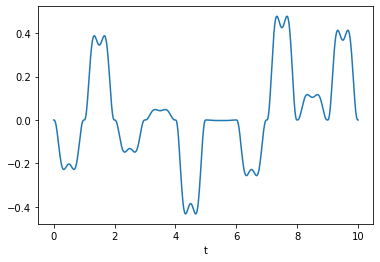

In [44]:
# Plot of the position trajectory
tt1 = np.linspace(t0-1, tf, 1000)
t_test = np.linspace(0, 10, 1000)
ax = plt.axis()
plt.plot(t_test, full_poly_func(t_test), zorder=-1)
plt.xlabel('t')

Text(0.5, 0, 't')

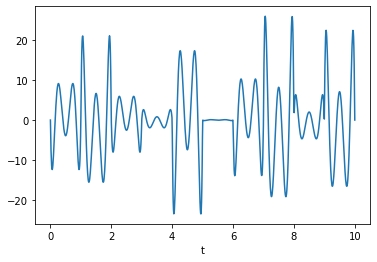

In [48]:
# Plot of the input trajectory
tt1 = np.linspace(t0-1, tf, 1000)
t_test = np.linspace(0, 10, 1000)
ax = plt.axis()
plt.plot(t_test, u_func(t_test), zorder=-1)
plt.xlabel('t')

## Simulation  to test effect on the real pendulum

In [ ]:
import pygent
from pygent.environments import CartPoleTriple

In [57]:
cost = lambda x, u: 0.
x0 = [0, np.pi, np.pi, np.pi, 0, 0, 0, 0]
time_step = 0.002
env = CartPoleTriple(cost, x0, time_step)

Model loaded
A matrix loaded
B matrix loaded
loading  /Users/MaxPritzkoleit/anaconda3/lib/python3.6/site-packages/PyGent-0.15-py3.6.egg/pygent/modeling_scripts/c_files/cart_pole_triple_lin_A.so
gcc -c -fPIC -lm /Users/MaxPritzkoleit/anaconda3/lib/python3.6/site-packages/PyGent-0.15-py3.6.egg/pygent/modeling_scripts/c_files/cart_pole_triple_lin_A.c -o /Users/MaxPritzkoleit/anaconda3/lib/python3.6/site-packages/PyGent-0.15-py3.6.egg/pygent/modeling_scripts/c_files/cart_pole_triple_lin_A.o

gcc -shared /Users/MaxPritzkoleit/anaconda3/lib/python3.6/site-packages/PyGent-0.15-py3.6.egg/pygent/modeling_scripts/c_files/cart_pole_triple_lin_A.o -o /Users/MaxPritzkoleit/anaconda3/lib/python3.6/site-packages/PyGent-0.15-py3.6.egg/pygent/modeling_scripts/c_files/cart_pole_triple_lin_A.so

loading  /Users/MaxPritzkoleit/anaconda3/lib/python3.6/site-packages/PyGent-0.15-py3.6.egg/pygent/modeling_scripts/c_files/cart_pole_triple_lin_A.so
loading  /Users/MaxPritzkoleit/anaconda3/lib/python3.6/site-pac

In [58]:
# Simulate
env.reset(x0)
for t in np.arange(0, tf, time_step):
    u = u_func(t)
    env.step([u])

(<Figure size 1800x1200 with 8 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x12f4fbc18>, <matplotlib.axes._subplots.AxesSubplot object at 0x12f5276a0>, <matplotlib.axes._subplots.AxesSubplot object at 0x12f702780>, <matplotlib.axes._subplots.AxesSubplot object at 0x12f7c8860>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12f148940>, <matplotlib.axes._subplots.AxesSubplot object at 0x12f44ec88>, <matplotlib.axes._subplots.AxesSubplot object at 0x12f4ec3c8>, <matplotlib.axes._subplots.AxesSubplot object at 0x12f579a20>], dtype=object))

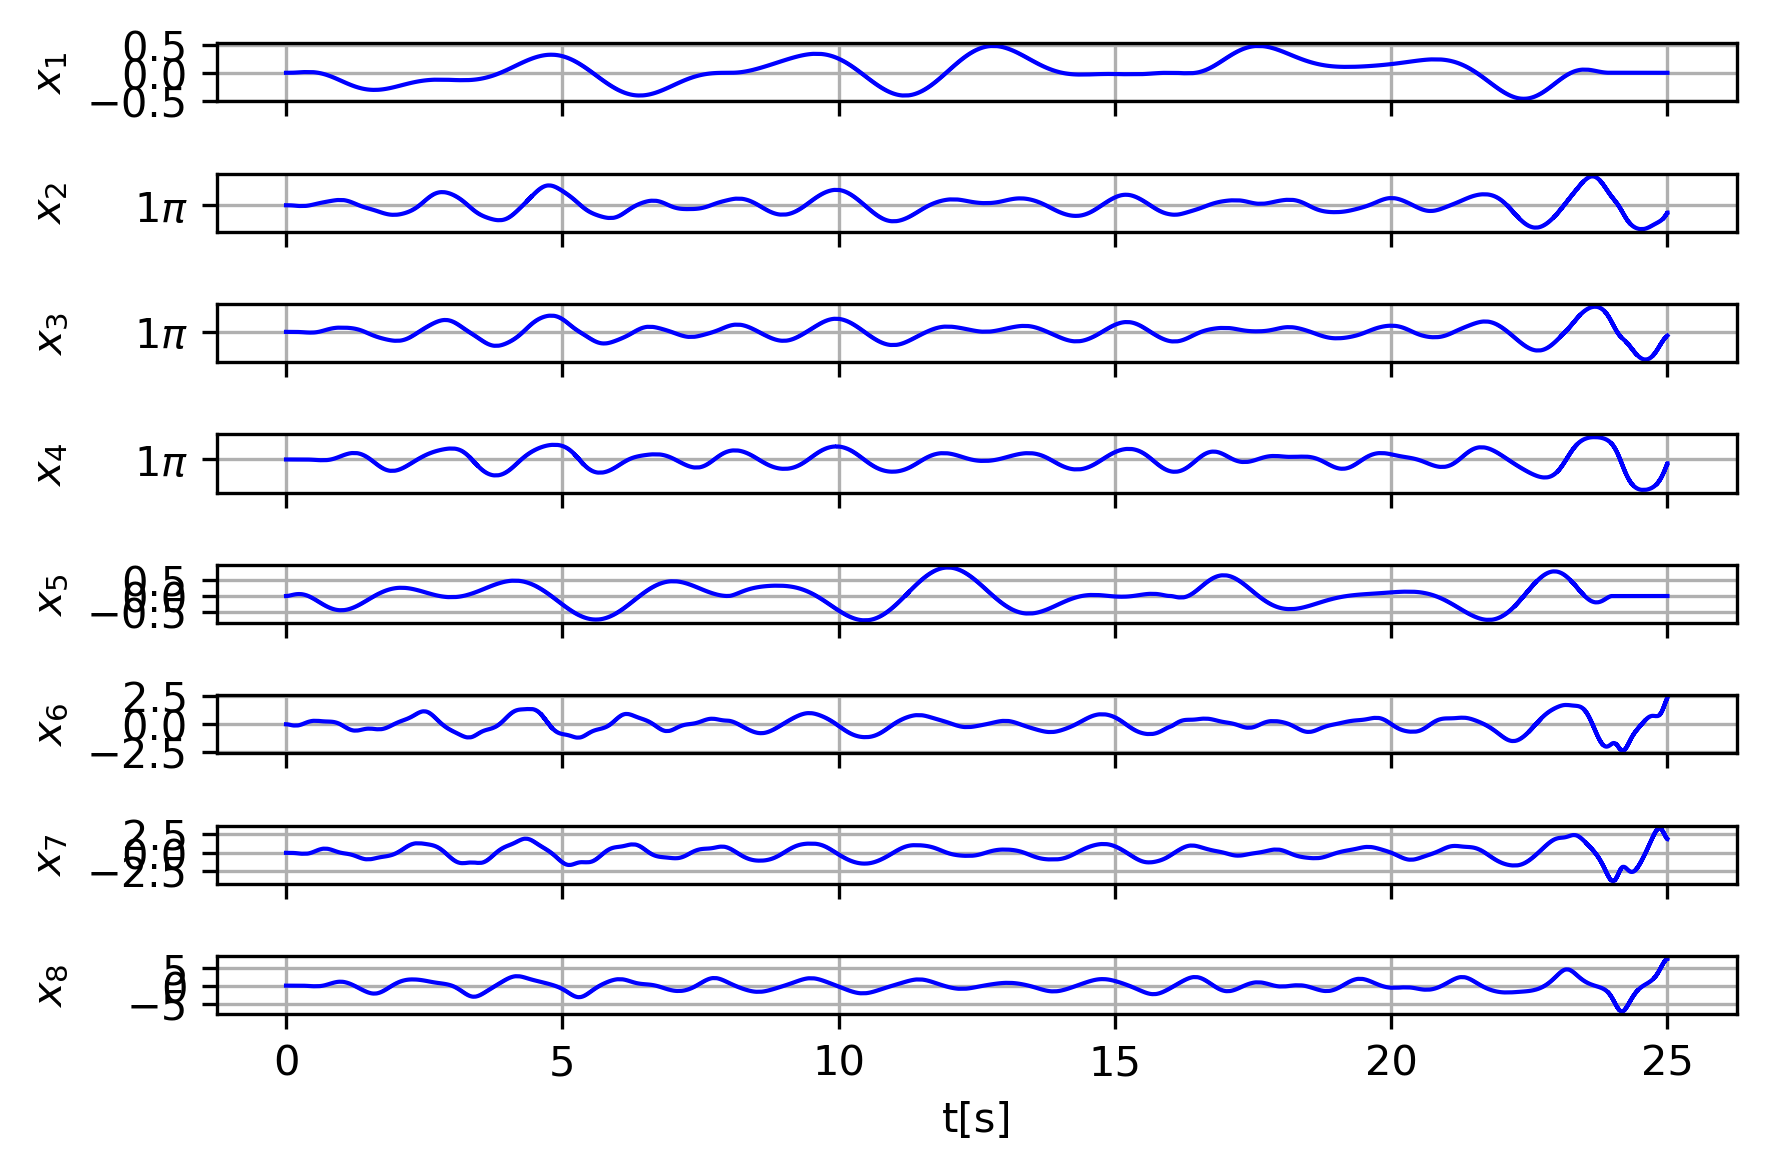

In [59]:
# Plot simulation results. State (cart position, angle 1, angle 2, angle 3, cart velocity, ...)
env.plot()

## Saving the .csv

In [61]:
import pickle
import numpy as np
import csv
import sys

folder = ''
dt = 0.002
tf = 25
tt = np.arange(0, tf, dt)
n = len(tt)

KK = np.zeros((n, 1, 8))
kk = np.zeros((n, 1, 1))
xx = env.history[:n, :] #set xx to be the simulated trajectory
uu = np.array([[u_func(t) for t in tt]]).T

fname = 'random'
# remap from x1 = cart position, x2 = angle 1, x3 = angle 2, x4 = angle 3 (velocities x5,...,x8)
# to x1 = angle 1, x2 = angle 2, x3 = angle 3, x4 = cart position (velocities x5,...,x8)

x_ref = np.concatenate((xx[:, 1:4], xx[:, 0:1], xx[:, 5:8], xx[:, 4:5]), axis=1)
K = np.concatenate((KK[:, 0, 1:4], KK[:, 0, 0:1], KK[:, 0, 5:8], KK[:, 0, 4:5]), axis=1)
k = kk.reshape(uu.shape)
u_ref = uu 

# create an array of the form: x_ref_1, ..., x_ref_8, u_ref_1, K_1, ..., K_8
feedback_array = np.concatenate((x_ref, u_ref, K), axis=1)

In [63]:
# resample to the new time step
dt_c = 0.002 #hard-coded
tt_c = np.arange(t0, tf, dt_c)
if dt_c != dt:
	#resample
	feedback_array_fnc = interp1d(tt, feedback_array, axis=0, kind='linear')
	feedback_array = feedback_array_fnc(tt_c)
	# save as .csv
out_str = feedback_array.astype(str) # convert to string

for idx, val in np.ndenumerate(out_str):
    # .encode() is necessary to convert str (which is unicode in python3) into bytes
    out_str[idx] = val.replace(".", ",").encode(encoding="utf-8")

fname_lv = fname + '.csv'
fname_np = fname + '_numpy.csv'

with open(fname_lv, "w") as f:
    writer = csv.writer(f, dialect=csv.excel_tab)
    writer.writerows(out_str)

np.savetxt(fname_np, feedback_array)
print("Files written:", fname_lv, fname_np)

Files written: random.csv random_numpy.csv
